In [ ]:
import sys
import os
import pandas as pd

# Python path ayarı
project_root = r"C:\Users\esram\OneDrive\Desktop\esrabecode\immo-eliza-ml"
sys.path.append(project_root)

# Fonksiyonları import et
from scripts.clean_data import clean_immo_data
from scripts.random_forest_model import run_pipeline_pipeline5, plot_random_forest_results
from scripts.xgboost_model import run_xgb_pipeline_basic, plot_xgb_pipeline_results

# Dosyayı temizle ve yükle
file_path = r"C:\Users\esram\OneDrive\Desktop\esrabecode\immo-eliza-ml\data\immovlan_cleaned_file_final.csv"
df = clean_immo_data(file_path)

# Random Forest pipeline
rf_params = {'n_estimators': 200}
model_rf, X_tr_rf, X_val_rf, X_test_rf, y_tr_rf, y_val_rf, y_test_rf = run_pipeline_pipeline5(
    df.copy(),
    rf_params=rf_params,
    cv=3,
    feature_eng=True,
    rare_city=True
)


In [ ]:
# CSV dosyasını oku
file_path = r"C:\Users\esram\OneDrive\Desktop\esrabecode\immo-eliza-ml\data\immovlan_cleaned_file_final.csv"
df = pd.read_csv(file_path)

# Price boş olanları çıkar
df = df.dropna(subset=['Price'])

In [ ]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats


In [ ]:
# Cell 2: Define the pipeline function for Pipeline 5
def run_pipeline_pipeline5(
    df, 
    target_col='Price', 
    rf_params=None,        # Random Forest parameters
    cv=3,                  # Cross-validation folds
    feature_eng=True,      # Apply feature engineering
    rare_city=True         # Handle rare cities
):
    df = df[df[target_col] > 1]

    # Drop unwanted columns
    drop_cols = ['Property ID', 'url','Availability','Attic','Kitchen equipment','Kitchen type',
                 'Furnished','Price_per_sqm_land','price_per_sqm','Number of facades',
                 'Number of bathrooms','Number of showers','Number of toilets',
                 'Surface garden','Type of glazing']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # Split data
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train_df = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
    X_val_df = pd.DataFrame(X_val, columns=X.columns, index=y_val.index)
    X_test_df = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)

    # Handle missing values
    zero_cols = ['Garage', 'Number of garages', 'Swimming pool', 'Terrace', 'Surface terrace','Elevator','Garden']
    categorical_cols = ['Type of heating', 'State of the property']

    for col in zero_cols:
        for df_ in [X_train_df, X_val_df, X_test_df]:
            df_[col].fillna(0, inplace=True)
    for col in categorical_cols:
        for df_ in [X_train_df, X_val_df, X_test_df]:
            df_[col].fillna('unknown', inplace=True)
    for df_ in [X_train_df, X_val_df, X_test_df]:
        df_['main_type'].fillna('unknown', inplace=True)

    # Fill total land surface for apartments
    X_train_df.loc[X_train_df['main_type']=='apartment','Total land surface'].fillna(0, inplace=True)
    X_val_df.loc[X_val_df['main_type']=='apartment','Total land surface'].fillna(0, inplace=True)
    X_test_df.loc[X_test_df['main_type']=='apartment','Total land surface'].fillna(0, inplace=True)

    # Fill medians for house and land
    house_median = X_train_df.loc[X_train_df['main_type']=='house','Total land surface'].median()
    land_median = X_train_df.loc[X_train_df['main_type']=='land','Total land surface'].median()
    for df_ in [X_train_df, X_val_df, X_test_df]:
        df_.loc[(df_['main_type']=='house') & (df_['Total land surface'].isna()), 'Total land surface'] = house_median
        df_.loc[(df_['main_type']=='land') & (df_['Total land surface'].isna()), 'Total land surface'] = land_median

    # Fill numeric columns by main_type median
    num_cols_for_median = ['Number of bedrooms', 'Livable surface', 'Total land surface']
    for col in num_cols_for_median:
        median_dict = X_train_df.groupby('main_type')[col].median()
        for mtype, med_val in median_dict.items():
            for df_ in [X_train_df, X_val_df, X_test_df]:
                df_.loc[(df_['main_type']==mtype) & (df_[col].isna()), col] = med_val
        median_val = X_train_df[col].median()
        for df_ in [X_train_df, X_val_df, X_test_df]:
            df_[col].fillna(median_val, inplace=True)

    # Remove outliers in train only
    outlier_num_cols = ['Number of bedrooms', 'Livable surface', 'Garage', 'Number of garages', 
                        'Terrace', 'Surface terrace', 'Total land surface', 'Swimming pool']
    df_normal_train_list = []
    y_train = y_train.reindex(X_train_df.index)
    for mtype, group in X_train_df.groupby('main_type'):
        group_copy = group.copy()
        group_copy[target_col] = y_train.loc[group_copy.index]
        z_scores = np.abs(stats.zscore(group_copy[outlier_num_cols], nan_policy='omit'))
        outliers = (z_scores > 3).any(axis=1)
        df_normal_train_list.append(group_copy[~outliers])
    df_normal_train = pd.concat(df_normal_train_list)

    X_tr = df_normal_train.drop(target_col, axis=1)
    y_tr = df_normal_train[target_col]
    X_val_copy = X_val_df.copy()
    X_test_copy = X_test_df.copy()

    # Handle rare cities
    if rare_city:
        freq = X_tr['city'].value_counts(normalize=True)
        rare_cities = freq[freq < 0.01].index
        for df_ in [X_tr, X_val_copy, X_test_copy]:
            df_['city'] = df_['city'].apply(lambda x: 'other' if x in rare_cities else x)

    # Feature engineering
    feat_eng_cols = ['has_swimming_pool', 'has_garden', 'has_terrace', 'surface_ratio', 'area_per_bedroom']
    if feature_eng:
        for df_ in [X_tr, X_val_copy, X_test_copy]:
            df_['has_swimming_pool'] = df_['Swimming pool'].apply(lambda x: 1 if x > 0 else 0)
            df_['has_garden'] = df_['Garden'].apply(lambda x: 1 if x > 0 else 0)
            df_['has_terrace'] = df_['Terrace'].apply(lambda x: 1 if x > 0 else 0)
            df_['surface_ratio'] = df_['Livable surface'] / df_['Total land surface'].replace(0,1)
            df_['area_per_bedroom'] = df_['Livable surface'] / df_['Number of bedrooms'].replace(0,1)

    # Encode categorical features
    cat_cols = ['State of the property', 'Type of heating','type', 'city', 'Region', 'province', 'main_type']
    cat_cols_existing = [c for c in cat_cols if c in X_tr.columns]

    X_tr_encoded = pd.get_dummies(X_tr, columns=cat_cols_existing, drop_first=True)
    X_val_encoded = pd.get_dummies(X_val_copy, columns=cat_cols_existing, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test_copy, columns=cat_cols_existing, drop_first=True)

    if feature_eng:
        for col in feat_eng_cols:
            X_tr_encoded[col] = X_tr[col]
            X_val_encoded[col] = X_val_copy[col]
            X_test_encoded[col] = X_test_copy[col]

    train_cols = X_tr_encoded.columns
    X_val_encoded = X_val_encoded.reindex(columns=train_cols, fill_value=0)
    X_test_encoded = X_test_encoded.reindex(columns=train_cols, fill_value=0)

    # Train Random Forest
    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1, **(rf_params or {}))
    model = rf_model.fit(X_tr_encoded, y_tr)

    # Predictions & evaluation
    y_train_pred = model.predict(X_tr_encoded)
    y_val_pred   = model.predict(X_val_encoded)
    y_test_pred  = model.predict(X_test_encoded)

    def evaluate(y_true, y_pred, label="Set"):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"{label} → RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

    evaluate(y_tr, y_train_pred, "Train")
    evaluate(y_val, y_val_pred, "Validation")
    evaluate(y_test, y_test_pred, "Test")

    return model, X_tr_encoded, X_val_encoded, X_test_encoded, y_tr, y_val, y_test


In [ ]:
# Cell 4: Run Pipeline 5 only
pipeline5_params = {
    'n_estimators': 200
}

model5, X_tr_enc, X_val_enc, X_test_enc, y_tr, y_val, y_test = run_pipeline_pipeline5(
    df.copy(),
    rf_params=pipeline5_params,
    cv=3,
    feature_eng=True,
    rare_city=True
)


C:\Users\esram\AppData\Local\Temp\ipykernel_21192\1883316811.py:73: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(group_copy[outlier_num_cols], nan_policy='omit'))
C:\Users\esram\AppData\Local\Temp\ipykernel_21192\1883316811.py:73: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(group_copy[outlier_num_cols], nan_policy='omit'))


Train → RMSE: 58894.20, MSE: 3468527051.86, MAE: 26088.57, R²: 0.9498
Validation → RMSE: 167167.70, MSE: 27945040259.78, MAE: 77061.36, R²: 0.6557
Test → RMSE: 230908.39, MSE: 53318683210.12, MAE: 81274.79, R²: 0.6602


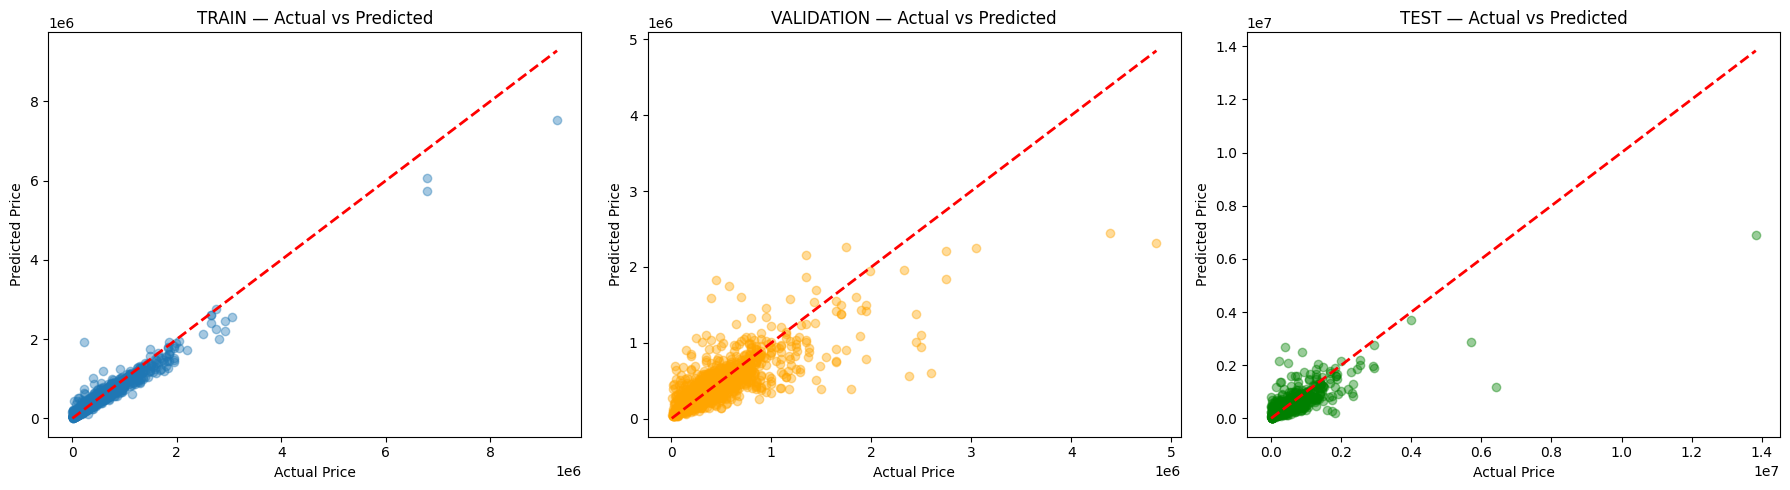

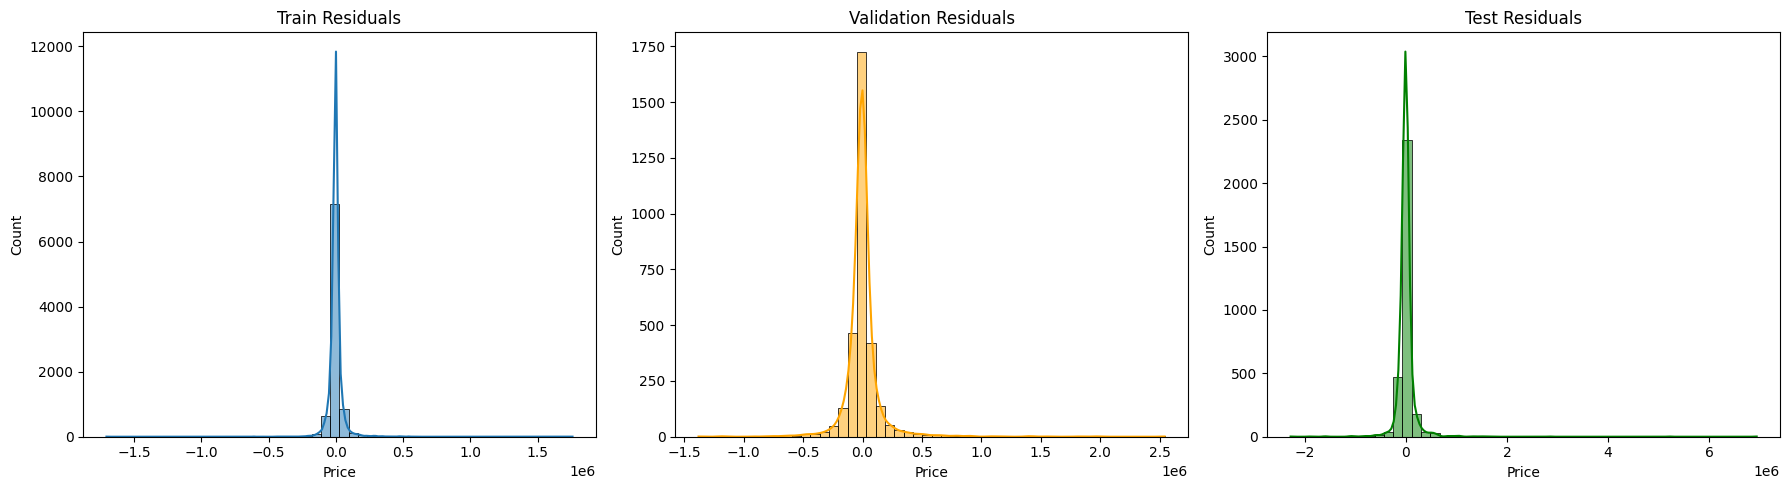

C:\Users\esram\AppData\Local\Temp\ipykernel_21192\903660078.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


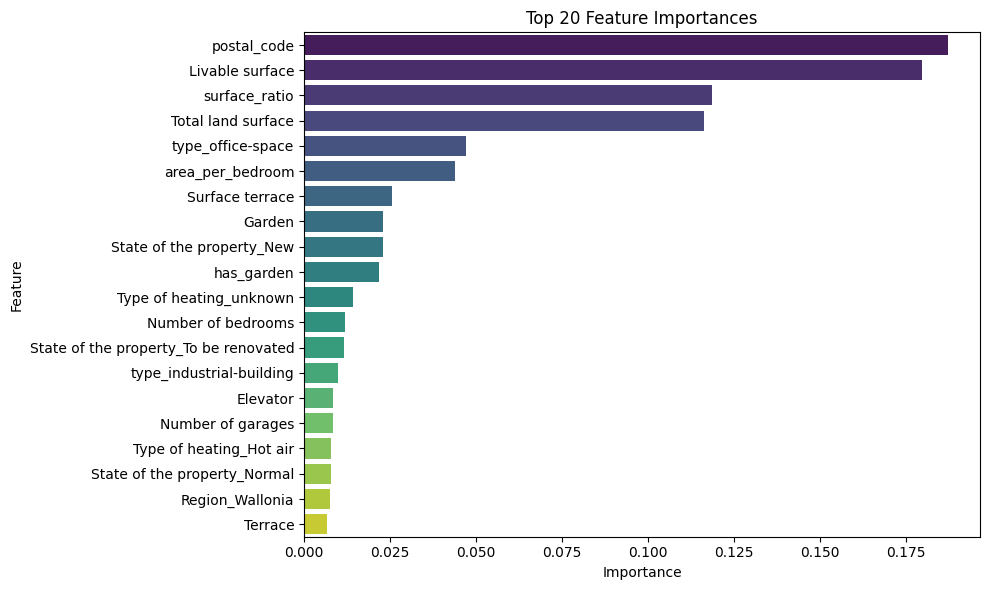

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_random_forest_results(model, X_tr, X_val, X_test, y_tr, y_val, y_test):
    """
    Plot Random Forest results:
    - Actual vs Predicted
    - Residuals
    - Feature Importance
    """

    # ---- Predictions ----
    y_train_pred = model.predict(X_tr)
    y_val_pred   = model.predict(X_val)
    y_test_pred  = model.predict(X_test)

    # ---- Actual vs Predicted ----
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(y_tr, y_train_pred, alpha=0.4)
    plt.title("TRAIN — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'r--', linewidth=2)

    plt.subplot(1, 3, 2)
    plt.scatter(y_val, y_val_pred, alpha=0.4, color="orange")
    plt.title("VALIDATION — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)

    plt.subplot(1, 3, 3)
    plt.scatter(y_test, y_test_pred, alpha=0.4, color="green")
    plt.title("TEST — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)

    plt.tight_layout()
    plt.show()

    # ---- Residuals ----
    plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    sns.histplot(y_tr - y_train_pred, bins=50, kde=True)
    plt.title("Train Residuals")
    
    plt.subplot(1,3,2)
    sns.histplot(y_val - y_val_pred, bins=50, kde=True, color="orange")
    plt.title("Validation Residuals")
    
    plt.subplot(1,3,3)
    sns.histplot(y_test - y_test_pred, bins=50, kde=True, color="green")
    plt.title("Test Residuals")
    
    plt.tight_layout()
    plt.show()

    # ---- Feature Importance ----
    importances = model.feature_importances_
    feature_names = X_tr.columns
    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()


plot_random_forest_results(model5, X_tr_enc, X_val_enc, X_test_enc, y_tr, y_val, y_test)


In [ ]:
plot_random_forest_results(model_rf, X_tr_rf, X_val_rf, X_test_rf, y_tr_rf, y_val_rf, y_test_rf)